# Capstone Project : Real or Not? NLP with Disaster Tweets

## Business Understanding

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

In this project , we will be building a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

Dataset is taken from Kaggle : https://www.kaggle.com/c/nlp-getting-started/data

**Project Overview :***
    
    1. EDA on the Dataset 
    2. Data Cleansing
    3. Apply Different Machine Learning Models and evaluate Results.
    4. Select the Best Performing Model and tune it to improve its performance
    5. Conclusion
    6. Future Improvements

**LET'S GOO!!!!**

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

In [2]:
# Import methods from Helper files
from ApplyClassificationModel import FitAndEvaluateMLModel,get_classification_model
from DataProcessing import get_cleaned_text, get_tags

In [3]:
# Import Training and test set Dataset
training_dataset = pd.read_csv(r"Data\DisasterTrain.csv")
test_dataset = pd.read_csv(f"Data\DisasterTest.csv")

In [4]:
training_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_dataset.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


## Exploratory Data Analysis on the Training Dataset

We are given two datasets, one for training and the other one for testing. We will be performing EDA on training dataset.

In [6]:
# Take a look at the length of the training dataset
training_dataset.shape

(7613, 5)

0    4342
1    3271
Name: target, dtype: int64


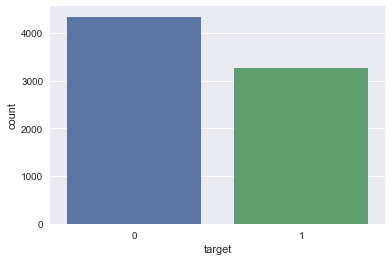

In [7]:
# Check the distribution of target label in the training set
print(training_dataset.target.value_counts())
sns.set(style="darkgrid")
ax = sns.countplot(x="target", data=training_dataset)

So, the number of fake disaster tweets are 4342 and real disaster tweets are 3271.

In [8]:
# Lets get the hashtags from all the tweets and see the most used ones in the entire dataset
training_dataset['hashtags'] = training_dataset.text.apply(lambda text : get_tags(text, '#'))

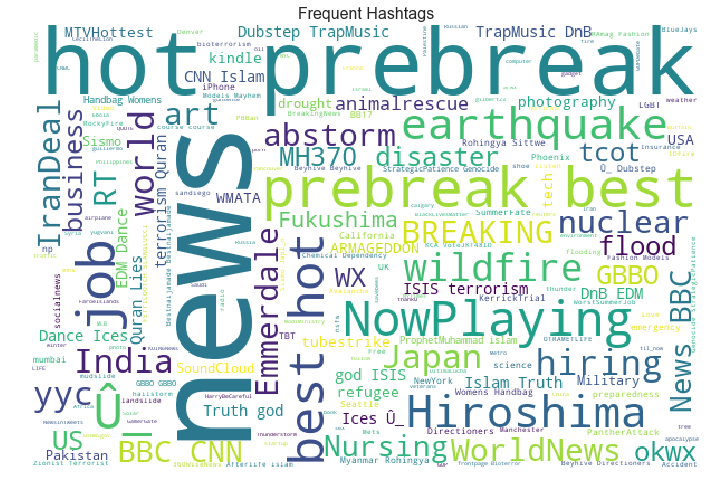

In [9]:
# We will be using word cloud to visualize the most prominent hashtags across all the tweets.
from wordcloud import WordCloud
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=[12, 12])
wordcloud = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(training_dataset['hashtags']))
ax1.imshow(wordcloud)
ax1.axis('off')
ax1.set_title('Frequent Hashtags',fontsize=16);

Hmm, so we have quite a lot of hashtags flowing in our dataset. Most Frequent Ones are : news, prebreak, best, nowplaying etc.

In [10]:
# Lets now visualize the locations from where most tweets were posted
locations_with_most_tweets = training_dataset.location.value_counts().to_frame().reset_index()

In [11]:
top_ten_locations = locations_with_most_tweets.rename(columns = {'location' : 'tweet_count', 'index': 'location', })[:10]

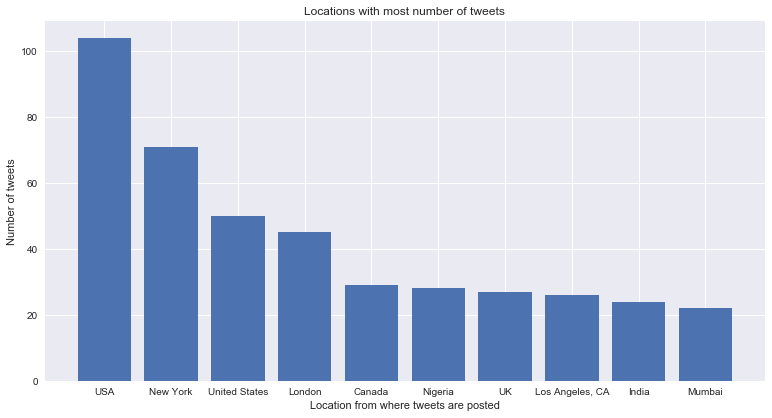

In [12]:
fig = plt.figure(figsize = [10,5])
ax = fig.add_axes([0,0,1,1])
ax.bar(top_ten_locations.location,top_ten_locations.tweet_count)
plt.xlabel('Location from where tweets are posted')
plt.ylabel('Number of tweets')
plt.title('Locations with most number of tweets')
plt.show()

In [13]:
top_ten_locations_with_fake_tweets = training_dataset[training_dataset['target'] == 1]['location'].value_counts().to_frame().reset_index()[:10]

In [14]:
top_ten_locations_with_fake_tweets.rename(columns =  {'location' : 'fake_tweet_count', 'index': 'location', }, inplace= True)

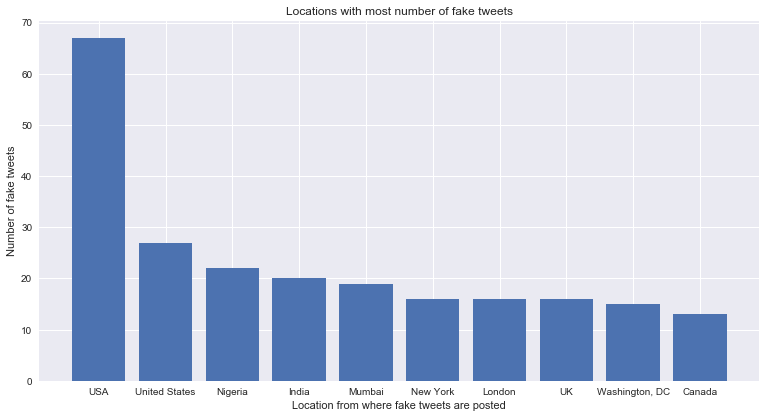

In [15]:
fig = plt.figure(figsize = [10,5])
ax = fig.add_axes([0,0,1,1])
ax.bar(top_ten_locations_with_fake_tweets.location,top_ten_locations_with_fake_tweets.fake_tweet_count)
plt.xlabel('Location from where fake tweets are posted')
plt.ylabel('Number of fake tweets')
plt.title('Locations with most number of fake tweets')
plt.show()

We can infer from the above two plots that the most number of tweets are from USA and most number of fake tweets are also from USA

## Data Preparation

Since, here we are dealing with text data, hence there is a need to process these tweets in order to keep only relevent information which is best suited for modelling.
In this data preparation process, I have created DataProcessing.py script, which :

    1. Normalizes the tweets to the lower format.
    2. Removes tags like #, @ from the words in the text.
    3. Removes punctuations.
    4. Removes stop words like is, the, on etc.
    5. Removes words which are of length less than 2.
    6. Removes alpha-numeric string.
    7. Reduces the words to their root forms using Lemmatization
    

In [16]:
# Let's test the get_cleaned_text method
print(f'Original Text : {training_dataset.text[0]}')
print(f'Cleaned Text : {get_cleaned_text(training_dataset.text[0])}')

Original Text : Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned Text : deed reason earthquake may allah forgive


Looks Good!. We can clearly see that :

    1. Text is transformed into lower case.
    2. # is removed from earthquake.
    3. Stop words are removed.
    4. Lemmatization of words : Reasons --> reason
    
Lets get the titles in the training set normalized to cleaned text

In [17]:
# Clean the train data
training_dataset.text = training_dataset.text.apply(lambda text : get_cleaned_text(text))

In [18]:
# Clean the test data
test_dataset.text = test_dataset.text.apply(lambda text : get_cleaned_text(text))

In [19]:
# Lets re-look at the training dataset
training_dataset.head()

,id,keyword,location,text,target,hashtags
0,1,NaN,NaN,deed reason earthquake may allah forgive,1,earthquake
1,4,NaN,NaN,forest fire near ronge sask canada,1,
2,5,NaN,NaN,resident ask shelter place notify officer evac...,1,
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1,wildfires
4,7,NaN,NaN,get sent photo ruby alaska smoke wildfires pou...,1,"Alaska,wildfires"


In [20]:
test_dataset.head()

,id,keyword,location,text,target
0,0,NaN,NaN,happen terrible car crash,1
1,2,NaN,NaN,heard earthquake different city stay safe ever...,1
2,3,NaN,NaN,forest fire spot pond geese flee across street...,1
3,9,NaN,NaN,apocalypse light spokane wildfire,1
4,11,NaN,NaN,typhoon soudelor kill china taiwan,1


## Fit and Evaluate Different Machine Learning Models

In [21]:
cv = CountVectorizer(max_features = 1500)
def get_independent_dependent_variables(dataset):  
    '''
    Returns the dependent and independent variables from the input dataset.
    
    Parameters :
        dataset (DataFrame) : Input Dataset
    '''
    text = dataset.text
    independent_variables = cv.fit_transform(text).toarray()
    dependent_variables = dataset.target
    
    return independent_variables,dependent_variables

In [22]:
x_train, y_train = get_independent_dependent_variables(training_dataset)

In [23]:
x_test, y_test = get_independent_dependent_variables(test_dataset)

Since, we are now ready with the data, lets fit different Machine Learning Models and evaluate the performance!

I have created a seperate ApplyClassificationModel file which has the utility functions for ML related operations 

In [25]:
FitAndEvaluateMLModel(x_train,y_train,x_test,y_test)

Accuracy using Decision Tree is :-  55.62365920931658
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      2084
           1       0.40      0.44      0.42      1179

    accuracy                           0.56      3263
   macro avg       0.53      0.53      0.53      3263
weighted avg       0.57      0.56      0.56      3263

Accuracy using Logistic Regression is :-  56.9414649095924
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      2084
           1       0.41      0.41      0.41      1179

    accuracy                           0.57      3263
   macro avg       0.54      0.54      0.54      3263
weighted avg       0.57      0.57      0.57      3263

Accuracy using Support Vector Machine is :-  63.867606497088566
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      2084
           1       0.00      0.00      0.00      1179

    a

**Logistic Regression** is the best suited model for the study. Let's try tuning it for better performance

## Model Tuning With Grid Search CV

In [26]:
lr_model = get_classification_model('LR')

In [27]:
lr_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 100)

# Create hyperparameter options for Logistic Regressor
lr_grid_params = dict(C=C, penalty=penalty)

In [29]:
lr_clf = GridSearchCV(lr_model, lr_grid_params, refit=True, verbose=2)

In [30]:
lr_clf.fit(x_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.1s
[CV] C=1.0, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................ C=1.0, penalty=l1, total=   0.1s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.1s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.1s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.1s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.1s
[CV] C=1.0974987654930561, penalty=l1 ................................
[CV] ................. C=1.0974987654930561, penalty=l1, total=   0.1s
[CV] C=1.0974987654930561, penalty=l1 ................................
[CV] ................. C=1.0974987654930561, penalty=l1, total=   0.1s
[CV] C=1.0974987654930561, penalty=l1 ................................
[CV] .

[CV] ................. C=2.3101297000831598, penalty=l2, total=   0.1s
[CV] C=2.535364493970112, penalty=l1 .................................
[CV] .................. C=2.535364493970112, penalty=l1, total=   0.1s
[CV] C=2.535364493970112, penalty=l1 .................................
[CV] .................. C=2.535364493970112, penalty=l1, total=   0.1s
[CV] C=2.535364493970112, penalty=l1 .................................
[CV] .................. C=2.535364493970112, penalty=l1, total=   0.1s
[CV] C=2.535364493970112, penalty=l2 .................................
[CV] .................. C=2.535364493970112, penalty=l2, total=   0.1s
[CV] C=2.535364493970112, penalty=l2 .................................
[CV] .................. C=2.535364493970112, penalty=l2, total=   0.1s
[CV] C=2.535364493970112, penalty=l2 .................................
[CV] .................. C=2.535364493970112, penalty=l2, total=   0.1s
[CV] C=2.782559402207125, penalty=l1 .................................
[CV] .

[CV] .................. C=5.857020818056667, penalty=l2, total=   0.1s
[CV] C=5.857020818056667, penalty=l2 .................................
[CV] .................. C=5.857020818056667, penalty=l2, total=   0.1s
[CV] C=6.428073117284322, penalty=l1 .................................
[CV] .................. C=6.428073117284322, penalty=l1, total=   0.1s
[CV] C=6.428073117284322, penalty=l1 .................................
[CV] .................. C=6.428073117284322, penalty=l1, total=   0.1s
[CV] C=6.428073117284322, penalty=l1 .................................
[CV] .................. C=6.428073117284322, penalty=l1, total=   0.1s
[CV] C=6.428073117284322, penalty=l2 .................................
[CV] .................. C=6.428073117284322, penalty=l2, total=   0.1s
[CV] C=6.428073117284322, penalty=l2 .................................
[CV] .................. C=6.428073117284322, penalty=l2, total=   0.1s
[CV] C=6.428073117284322, penalty=l2 .................................
[CV] .

[CV] .................. C=14.84968262254465, penalty=l2, total=   0.1s
[CV] C=14.84968262254465, penalty=l2 .................................
[CV] .................. C=14.84968262254465, penalty=l2, total=   0.1s
[CV] C=14.84968262254465, penalty=l2 .................................
[CV] .................. C=14.84968262254465, penalty=l2, total=   0.1s
[CV] C=16.297508346206442, penalty=l1 ................................
[CV] ................. C=16.297508346206442, penalty=l1, total=   0.1s
[CV] C=16.297508346206442, penalty=l1 ................................
[CV] ................. C=16.297508346206442, penalty=l1, total=   0.1s
[CV] C=16.297508346206442, penalty=l1 ................................
[CV] ................. C=16.297508346206442, penalty=l1, total=   0.1s
[CV] C=16.297508346206442, penalty=l2 ................................
[CV] ................. C=16.297508346206442, penalty=l2, total=   0.1s
[CV] C=16.297508346206442, penalty=l2 ................................
[CV] .

[CV] ................. C=37.649358067924695, penalty=l1, total=   0.3s
[CV] C=37.649358067924695, penalty=l2 ................................
[CV] ................. C=37.649358067924695, penalty=l2, total=   0.1s
[CV] C=37.649358067924695, penalty=l2 ................................
[CV] ................. C=37.649358067924695, penalty=l2, total=   0.1s
[CV] C=37.649358067924695, penalty=l2 ................................
[CV] ................. C=37.649358067924695, penalty=l2, total=   0.1s
[CV] C=41.32012400115339, penalty=l1 .................................
[CV] .................. C=41.32012400115339, penalty=l1, total=   0.4s
[CV] C=41.32012400115339, penalty=l1 .................................
[CV] .................. C=41.32012400115339, penalty=l1, total=   0.2s
[CV] C=41.32012400115339, penalty=l1 .................................
[CV] .................. C=41.32012400115339, penalty=l1, total=   0.3s
[CV] C=41.32012400115339, penalty=l2 .................................
[CV] .

[CV] .................. C=95.45484566618342, penalty=l1, total=   0.6s
[CV] C=95.45484566618342, penalty=l1 .................................
[CV] .................. C=95.45484566618342, penalty=l1, total=   0.4s
[CV] C=95.45484566618342, penalty=l1 .................................
[CV] .................. C=95.45484566618342, penalty=l1, total=   0.3s
[CV] C=95.45484566618342, penalty=l2 .................................
[CV] .................. C=95.45484566618342, penalty=l2, total=   0.1s
[CV] C=95.45484566618342, penalty=l2 .................................
[CV] .................. C=95.45484566618342, penalty=l2, total=   0.2s
[CV] C=95.45484566618342, penalty=l2 .................................
[CV] .................. C=95.45484566618342, penalty=l2, total=   0.1s
[CV] C=104.76157527896652, penalty=l1 ................................
[CV] ................. C=104.76157527896652, penalty=l1, total=   0.5s
[CV] C=104.76157527896652, penalty=l1 ................................
[CV] .

[CV] ................. C=220.51307399030458, penalty=l2, total=   0.2s
[CV] C=220.51307399030458, penalty=l2 ................................
[CV] ................. C=220.51307399030458, penalty=l2, total=   0.2s
[CV] C=242.01282647943833, penalty=l1 ................................
[CV] ................. C=242.01282647943833, penalty=l1, total=   0.4s
[CV] C=242.01282647943833, penalty=l1 ................................
[CV] ................. C=242.01282647943833, penalty=l1, total=   0.5s
[CV] C=242.01282647943833, penalty=l1 ................................
[CV] ................. C=242.01282647943833, penalty=l1, total=   0.4s
[CV] C=242.01282647943833, penalty=l2 ................................
[CV] ................. C=242.01282647943833, penalty=l2, total=   0.2s
[CV] C=242.01282647943833, penalty=l2 ................................
[CV] ................. C=242.01282647943833, penalty=l2, total=   0.2s
[CV] C=242.01282647943833, penalty=l2 ................................
[CV] .

[CV] .................. C=559.0810182512229, penalty=l1, total=   0.6s
[CV] C=559.0810182512229, penalty=l2 .................................
[CV] .................. C=559.0810182512229, penalty=l2, total=   0.2s
[CV] C=559.0810182512229, penalty=l2 .................................
[CV] .................. C=559.0810182512229, penalty=l2, total=   0.2s
[CV] C=559.0810182512229, penalty=l2 .................................
[CV] .................. C=559.0810182512229, penalty=l2, total=   0.2s
[CV] C=613.5907273413176, penalty=l1 .................................
[CV] .................. C=613.5907273413176, penalty=l1, total=   0.7s
[CV] C=613.5907273413176, penalty=l1 .................................
[CV] .................. C=613.5907273413176, penalty=l1, total=   0.4s
[CV] C=613.5907273413176, penalty=l1 .................................
[CV] .................. C=613.5907273413176, penalty=l1, total=   0.4s
[CV] C=613.5907273413176, penalty=l2 .................................
[CV] .

[CV] C=1417.4741629268062, penalty=l1 ................................
[CV] ................. C=1417.4741629268062, penalty=l1, total=   0.9s
[CV] C=1417.4741629268062, penalty=l1 ................................
[CV] ................. C=1417.4741629268062, penalty=l1, total=   0.4s
[CV] C=1417.4741629268062, penalty=l1 ................................
[CV] ................. C=1417.4741629268062, penalty=l1, total=   0.4s
[CV] C=1417.4741629268062, penalty=l2 ................................
[CV] ................. C=1417.4741629268062, penalty=l2, total=   0.2s
[CV] C=1417.4741629268062, penalty=l2 ................................
[CV] ................. C=1417.4741629268062, penalty=l2, total=   0.2s
[CV] C=1417.4741629268062, penalty=l2 ................................
[CV] ................. C=1417.4741629268062, penalty=l2, total=   0.2s
[CV] C=1555.6761439304723, penalty=l1 ................................
[CV] ................. C=1555.6761439304723, penalty=l1, total=   0.7s
[CV] C

[CV] ................. C=3274.5491628777318, penalty=l2, total=   0.3s
[CV] C=3274.5491628777318, penalty=l2 ................................
[CV] ................. C=3274.5491628777318, penalty=l2, total=   0.2s
[CV] C=3593.8136638046294, penalty=l1 ................................
[CV] ................. C=3593.8136638046294, penalty=l1, total=   0.8s
[CV] C=3593.8136638046294, penalty=l1 ................................
[CV] ................. C=3593.8136638046294, penalty=l1, total=   0.5s
[CV] C=3593.8136638046294, penalty=l1 ................................
[CV] ................. C=3593.8136638046294, penalty=l1, total=   0.6s
[CV] C=3593.8136638046294, penalty=l2 ................................
[CV] ................. C=3593.8136638046294, penalty=l2, total=   0.3s
[CV] C=3593.8136638046294, penalty=l2 ................................
[CV] ................. C=3593.8136638046294, penalty=l2, total=   0.3s
[CV] C=3593.8136638046294, penalty=l2 ................................
[CV] .

[CV] .................. C=8302.175681319752, penalty=l1, total=   0.6s
[CV] C=8302.175681319752, penalty=l2 .................................
[CV] .................. C=8302.175681319752, penalty=l2, total=   0.4s
[CV] C=8302.175681319752, penalty=l2 .................................
[CV] .................. C=8302.175681319752, penalty=l2, total=   0.4s
[CV] C=8302.175681319752, penalty=l2 .................................
[CV] .................. C=8302.175681319752, penalty=l2, total=   0.2s
[CV] C=9111.627561154895, penalty=l1 .................................
[CV] .................. C=9111.627561154895, penalty=l1, total=   0.8s
[CV] C=9111.627561154895, penalty=l1 .................................
[CV] .................. C=9111.627561154895, penalty=l1, total=   0.2s
[CV] C=9111.627561154895, penalty=l1 .................................
[CV] .................. C=9111.627561154895, penalty=l1, total=   0.6s
[CV] C=9111.627561154895, penalty=l2 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  2.7min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00...
       8.111e+02, 8.902e+02, 9.770e+02, 1.072e+03, 1.177e+03, 1.292e+03,
       1.417e+03, 1.556e+03, 1.707e+03, 1.874e+03, 2.057e+03, 2.257e+03,
       2.477e+03, 2.719e+03, 2.984e+03, 3.275e+03, 3.594e+03, 3.944e+03,
       4.329e+03, 4.751e+03, 5.214e+03, 5.722e+03, 6.280e+03, 6.893e+03,
 

In [31]:
lr_clf.best_score_

0.6923683173518981

We can clearly see that the accuracy for Logistic Regression is increased from **56%** to **69%**!!!!!

## Conclusion

From the study, we can infer that :
    
    1. Below performance was observed on applying different ML techniques on the processed dataset :  

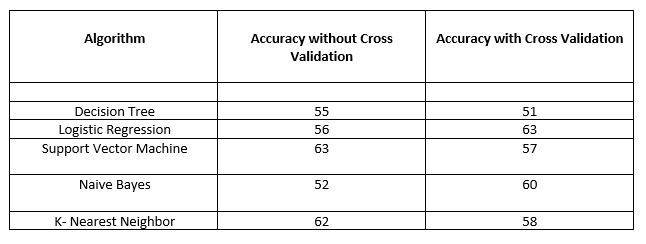

        
    2. Logistic Regressor Model can be the go-to algorithm to solve our problem.
    3. On Tuning the model, we are able to increase the accuracy from 56% to 69%.  

## Future Improvements

1. We can try applying Deep Learning Algorithm and observe the results.
2. We can also use GloVe or word embeddings in our dataset and observe the results on applying ML algorithms.